In [182]:
## Load required libraries and datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re
from collections import Counter
from scipy.stats import t
from statistics import stdev

import matplotlib.dates as mdates
import missingno

#remove all warnings
import warnings
warnings.filterwarnings("ignore")


In [183]:
## import data
all_data=pd.read_csv("./csv_folders/QVI_data.csv")
all_data.head(5)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [184]:
all_data.shape

(264834, 12)

<AxesSubplot:>

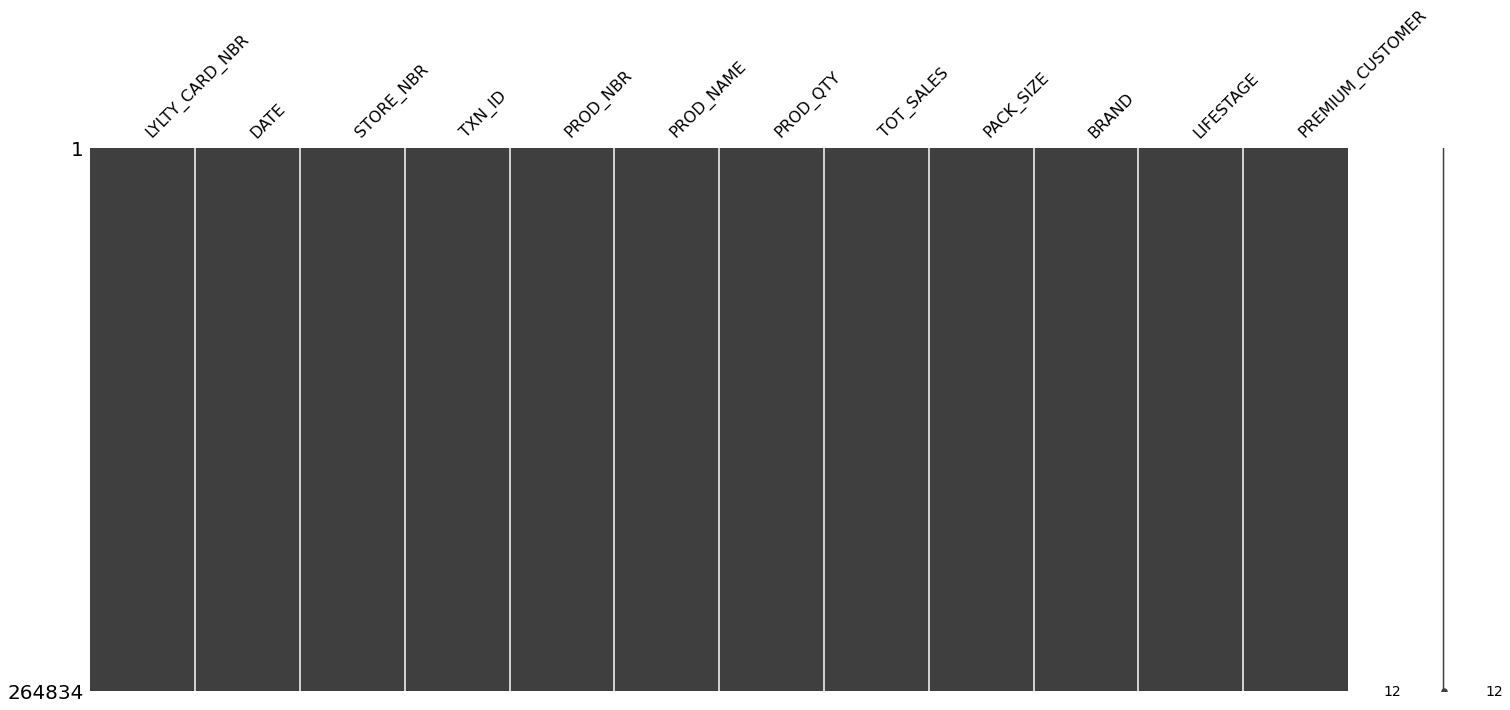

In [185]:
##checking missing values and duplicates
missingno.matrix(all_data)

## Select control stores
The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [186]:
## Create Yearmonth feature
all_data["YEARMONTH"]=[''.join(x.split('-')[0:2]) for x in all_data["DATE"]]
all_data["YEARMONTH"]=pd.to_numeric(all_data["YEARMONTH"])
all_data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [187]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
 12  YEARMONTH         264834 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 21.2+ MB


 For each store and month calculate
 - total sales
 - number of customers
 - transactions per customer
 - chips per customer
 -average price per unit

In [188]:
## totoal sales
totSales=all_data.groupby(["STORE_NBR","YEARMONTH"]).TOT_SALES.sum()
totSales

STORE_NBR  YEARMONTH
1          201807       206.9
           201808       176.1
           201809       278.8
           201810       188.1
           201811       192.6
                        ...  
272        201902       395.5
           201903       442.3
           201904       445.1
           201905       314.6
           201906       312.1
Name: TOT_SALES, Length: 3169, dtype: float64

In [189]:
## number of customers
numCust=all_data.groupby(["STORE_NBR","YEARMONTH"]).LYLTY_CARD_NBR.nunique()
numCust

STORE_NBR  YEARMONTH
1          201807       49
           201808       42
           201809       59
           201810       44
           201811       46
                        ..
272        201902       45
           201903       50
           201904       54
           201905       34
           201906       34
Name: LYLTY_CARD_NBR, Length: 3169, dtype: int64

In [190]:
## transactin per customer
## unique transaction ID divided by unique loyalty card number
transPerCust=all_data.groupby(["STORE_NBR","YEARMONTH"]).TXN_ID.nunique()/all_data.groupby(["STORE_NBR","YEARMONTH"]).LYLTY_CARD_NBR.nunique()
transPerCust

STORE_NBR  YEARMONTH
1          201807       1.061224
           201808       1.023810
           201809       1.050847
           201810       1.022727
           201811       1.021739
                          ...   
272        201902       1.066667
           201903       1.060000
           201904       1.018519
           201905       1.176471
           201906       1.088235
Length: 3169, dtype: float64

In [191]:
## chips per customers
## TOTAL_SALES divided by PROD_QTY
avgPricePerCust=all_data.groupby(["STORE_NBR","YEARMONTH"]).TOT_SALES.sum()/all_data.groupby(["STORE_NBR","YEARMONTH"]).PROD_QTY.sum()
avgPricePerCust

STORE_NBR  YEARMONTH
1          201807       3.337097
           201808       3.261111
           201809       3.717333
           201810       3.243103
           201811       3.378947
                          ...   
272        201902       4.346154
           201903       4.379208
           201904       4.239048
           201905       4.430986
           201906       4.458571
Length: 3169, dtype: float64

In [192]:
# combine all
dataframes=[totSales,numCust,transPerCust,avgPricePerCust]
measure_over_time=pd.concat(dataframes,join='outer',axis=1)
measure_over_time.rename(columns={"TOT_SALES":'totSales',"LYLTY_CARD_NBR":"numCust",0:"transPerCust",1:"avgPricePerCust"},inplace=True)
measure_over_time

totSales  numCust  transPerCust  avgPricePerCust
STORE_NBR YEARMONTH                                                  
1         201807        206.9       49      1.061224         3.337097
          201808        176.1       42      1.023810         3.261111
          201809        278.8       59      1.050847         3.717333
          201810        188.1       44      1.022727         3.243103
          201811        192.6       46      1.021739         3.378947
...                       ...      ...           ...              ...
272       201902        395.5       45      1.066667         4.346154
          201903        442.3       50      1.060000         4.379208
          201904        445.1       54      1.018519         4.239048
          201905        314.6       34      1.176471         4.430986
          201906        312.1       34      1.088235         4.458571

[3169 rows x 4 columns]

In [193]:
#### Filter to the pre-trial period and stores with full observation periods
# build pivot to check months with no transactions

a=pd.pivot_table(all_data,values="TXN_ID",index="STORE_NBR",columns="YEARMONTH",aggfunc="count")
a

YEARMONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [194]:
a.isnull().sum()

YEARMONTH
201807    6
201808    9
201809    8
201810    7
201811    8
201812    9
201901    9
201902    8
201903    7
201904    7
201905    9
201906    8
dtype: int64

<AxesSubplot:>

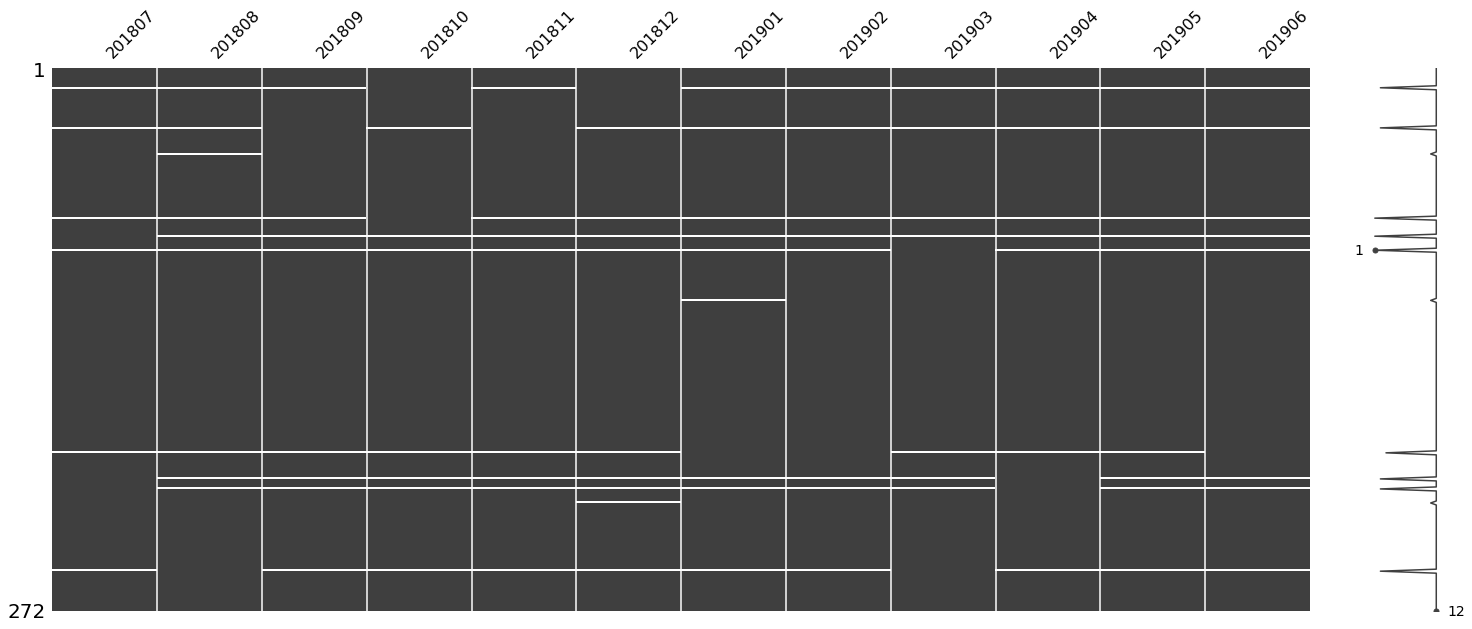

In [195]:
#visualise
missingno.matrix(a)

In [196]:
# stores that don't have full observation periods
null_store=a[a.isnull().any(axis=1)].index
null_store

Int64Index([11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252], dtype='int64', name='STORE_NBR')

In [197]:
#remove null stores from measure over time
measure_over_time.reset_index(inplace=True)
measure_over_time

,STORE_NBR,YEARMONTH,totSales,numCust,transPerCust,avgPricePerCust
0,1,201807,206.9,49,1.061224,3.337097
1,1,201808,176.1,42,1.023810,3.261111
2,1,201809,278.8,59,1.050847,3.717333
3,1,201810,188.1,44,1.022727,3.243103
4,1,201811,192.6,46,1.021739,3.378947
...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,4.346154
3165,272,201903,442.3,50,1.060000,4.379208
3166,272,201904,445.1,54,1.018519,4.239048
3167,272,201905,314.6,34,1.176471,4.430986


In [198]:
#Before dropping
measure_over_time.shape

(3169, 6)

In [199]:
measure_over_time=measure_over_time[~measure_over_time["STORE_NBR"].isin(null_store)]
measure_over_time.shape

(3120, 6)

In [200]:
#filter period leass than Febaurary 2019
perTialMeasures=measure_over_time.loc[measure_over_time["YEARMONTH"]<201902,:]
perTialMeasures.shape

(1820, 6)

In [201]:
perTialMeasures.sample(5)

,STORE_NBR,YEARMONTH,totSales,numCust,transPerCust,avgPricePerCust
306,27,201811,403.10,46,1.000000,4.478889
1989,171,201811,409.20,48,1.041667,4.092000
1278,112,201807,998.80,106,1.349057,3.420548
3158,272,201808,372.85,44,1.090909,4.386471
2820,243,201808,410.30,55,1.072727,3.663393


In [202]:
###  Create function to calculate correlation



##############JUST Sketch##############
# a=perTialMeasures.loc[perTialMeasures["STORE_NBR"]==77,"totSales"]
# b=perTialMeasures.loc[perTialMeasures["STORE_NBR"]==1,"totSales"]
# a.reset_index(drop=True,inplace=True)
# b.reset_index(drop=True,inplace=True)
# b.corr(a)
########################################

def calculate_correlation(input_df:pd.DataFrame,metric:str,storeComparison:int):
    
    """[
        Calculated the correlation between the metric of the controled stores
        INPUT: input_df:input_data set
        metric: feature of the store
        storeComparison: number of the store to be compared with respect to the rest of the controled stores

    ]

    Returns:
        [output_df]: [pd.DataFrame]
    """
    output_df=pd.DataFrame({"Store_1":[],"Store_2":[],"Correlation":[]})
    
    ## a is for Store_1 
    a=input_df.loc[input_df["STORE_NBR"]==storeComparison,metric]
    a.reset_index(drop=True,inplace=True)

    # ## iterate other stores to get correlation with Store_1
    others_store=input_df["STORE_NBR"].unique()
    for i in others_store:
        b=input_df.loc[input_df["STORE_NBR"]==i,metric]
        b.reset_index(drop=True,inplace=True)
        output_df=output_df.append({"Store_1":storeComparison,"Store_2":i,"Correlation":b.corr(a)},ignore_index=True)
    
    return output_df

In [203]:
### Create a function to calculate a standardised magnitude distance for a measure
#########Sketch##############
# c=perTialMeasures.loc[perTialMeasures["STORE_NBR"]==77,'totSales']
# np.mean((1-(c-min(c)))/(max(c)-min(c)))
############################
def calculate_std_magnitude_distance(input_df:pd.DataFrame,metric:str,storeComparison:int):
    
    """[
        Calculated the standardised magnitude distance between the metric of the controled stores
        INPUT: input_df:input_data set
        metric: feature of the store
        storeComparison: number of the store to be compared with respect to the rest of the controled stores

    ]

    Returns:
        [output_df]: [pd.DataFrame]
    """
    output_df=pd.DataFrame({"Store_1":[],"Store_2":[],"Magnitude":[]})
    
    ## a is for Store_1 
    a=input_df.loc[input_df["STORE_NBR"]==storeComparison,metric]
    a.reset_index(drop=True,inplace=True)

    # ## iterate other stores to get correlation with Store_1
    others_store=input_df["STORE_NBR"].unique()
    for i in others_store:
        b=input_df.loc[input_df["STORE_NBR"]==i,metric]
        b.reset_index(drop=True,inplace=True)
        c=abs(a-b)
        d=np.mean(1-(c-min(c))/(max(c)-min(c)))
        output_df=output_df.append({"Store_1":storeComparison,"Store_2":i,"Magnitude":d},ignore_index=True)
    
    return output_df

Now let's use the functions to find the control stores! We'll select control stores
based on how similar monthly total sales in dollar amounts and monthly number of 
customers are to the trial stores. So we will need to use our functions to get four
scores, two for each of total sales and total customers.

## SELECTING CONTROL STORE FOR TRIAL STORE 77

In [204]:
## calculate correlations against store 77 using total sales and number of customers.
tot_sales_corr=calculate_correlation(perTialMeasures,"totSales",77)
num_cus_corr=calculate_correlation(perTialMeasures,"numCust",77)

tot_sales_std_dist=calculate_std_magnitude_distance(perTialMeasures,"totSales",77)
num_cus_std_dist=calculate_std_magnitude_distance(perTialMeasures,"numCust",77)

In [205]:
tot_sales_corr.head()

,Store_1,Store_2,Correlation
0,77.0,1.0,0.075218
1,77.0,2.0,-0.263079
2,77.0,3.0,0.806644
3,77.0,4.0,-0.263300
4,77.0,5.0,-0.110652


In [206]:
tot_sales_std_dist.head()

,Store_1,Store_2,Magnitude
0,77.0,1.0,0.408163
1,77.0,2.0,0.590119
2,77.0,3.0,0.522914
3,77.0,4.0,0.644934
4,77.0,5.0,0.516320


In [207]:
### Concatenate into one score_nSales df
score_nSales=pd.concat([tot_sales_corr,tot_sales_std_dist["Magnitude"]],axis=1)
score_nSales

,Store_1,Store_2,Correlation,Magnitude
0,77.0,1.0,0.075218,0.408163
1,77.0,2.0,-0.263079,0.590119
2,77.0,3.0,0.806644,0.522914
3,77.0,4.0,-0.263300,0.644934
4,77.0,5.0,-0.110652,0.516320
...,...,...,...,...
255,77.0,268.0,0.344757,0.429787
256,77.0,269.0,-0.315730,0.559099
257,77.0,270.0,0.315430,0.591547
258,77.0,271.0,0.355487,0.341091


Let's take a simple average of the correlation and magnitude scores for each 
driver. Note that if we consider it more important for the trend of the drivers to 
be similar, we can increase the weight of the correlation score (a simple average 
gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of 
the drivers to be more important, we can lower the weight of the correlation score.

In [208]:
## Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table
### FOR TOTAL sales

corr_score=0.5

score_nSales["combined_score"]=corr_score*score_nSales["Correlation"]+corr_score*score_nSales["Magnitude"]
score_nSales

,Store_1,Store_2,Correlation,Magnitude,combined_score
0,77.0,1.0,0.075218,0.408163,0.241691
1,77.0,2.0,-0.263079,0.590119,0.163520
2,77.0,3.0,0.806644,0.522914,0.664779
3,77.0,4.0,-0.263300,0.644934,0.190817
4,77.0,5.0,-0.110652,0.516320,0.202834
...,...,...,...,...,...
255,77.0,268.0,0.344757,0.429787,0.387272
256,77.0,269.0,-0.315730,0.559099,0.121684
257,77.0,270.0,0.315430,0.591547,0.453489
258,77.0,271.0,0.355487,0.341091,0.348289


In [209]:
### For number of customers
score_nCus=pd.concat([num_cus_corr,num_cus_std_dist["Magnitude"]],axis=1)
score_nCus

,Store_1,Store_2,Correlation,Magnitude
0,77.0,1.0,0.322168,0.663866
1,77.0,2.0,-0.572051,0.471429
2,77.0,3.0,0.834207,0.489796
3,77.0,4.0,-0.295639,0.498258
4,77.0,5.0,0.370659,0.512605
...,...,...,...,...
255,77.0,268.0,0.369517,0.571429
256,77.0,269.0,-0.474293,0.484472
257,77.0,270.0,-0.131259,0.536680
258,77.0,271.0,0.019629,0.328571


In [210]:
#Combined Score
score_nCus["combined_score"]=(corr_score*score_nCus["Correlation"]+corr_score*score_nCus["Magnitude"])
score_nCus

,Store_1,Store_2,Correlation,Magnitude,combined_score
0,77.0,1.0,0.322168,0.663866,0.493017
1,77.0,2.0,-0.572051,0.471429,-0.050311
2,77.0,3.0,0.834207,0.489796,0.662002
3,77.0,4.0,-0.295639,0.498258,0.101310
4,77.0,5.0,0.370659,0.512605,0.441632
...,...,...,...,...,...
255,77.0,268.0,0.369517,0.571429,0.470473
256,77.0,269.0,-0.474293,0.484472,0.005090
257,77.0,270.0,-0.131259,0.536680,0.202710
258,77.0,271.0,0.019629,0.328571,0.174100


In [211]:
###  Combine scores across the drivers by first merging our sales scores and customer scores into a single table
### index both "score_nCus" dataframe and "score_nSales" dataframe
score_nSales.set_index(["Store_1","Store_2"],inplace=True)
score_nCus.set_index(["Store_1","Store_2"],inplace=True)

In [212]:
### just combine two scores into new dataframe
score_Control=pd.concat([score_nSales["combined_score"],score_nCus["combined_score"]],axis=1)
score_Control.columns=["score_NSales","score_NCus"]
score_Control

score_NSales  score_NCus
Store_1 Store_2                          
77.0    1.0          0.241691    0.493017
        2.0          0.163520   -0.050311
        3.0          0.664779    0.662002
        4.0          0.190817    0.101310
        5.0          0.202834    0.441632
...                       ...         ...
        268.0        0.387272    0.470473
        269.0        0.121684    0.005090
        270.0        0.453489    0.202710
        271.0        0.348289    0.174100
        272.0        0.320626    0.384336

[260 rows x 2 columns]

In [213]:
# Now we have a score for each of total number of sales and number of customers. 
# Let's combine the two via a simple average.

score_Control["finalControlScore"]=score_Control["score_NSales"]*0.5+score_Control["score_NCus"]*0.5
score_Control.sort_values(by="finalControlScore",ascending=False)

score_NSales  score_NCus  finalControlScore
Store_1 Store_2                                             
77.0    233.0        0.697290    0.816607           0.756949
        71.0         0.789497    0.663123           0.726310
        84.0         0.656972    0.715000           0.685986
        119.0        0.636046    0.729729           0.682887
        115.0        0.708347    0.645155           0.676751
...                       ...         ...                ...
        242.0       -0.121818   -0.046675          -0.084247
        186.0       -0.128806   -0.057268          -0.093037
        102.0       -0.102238   -0.119121          -0.110680
        9.0         -0.144121   -0.087135          -0.115628
        77.0              NaN         NaN                NaN

[260 rows x 3 columns]

The store with the highest score is then selected as the control store since it is 
most similar to the trial store.

IN this case store number "233"

In [214]:
control_store=233
trial_store=77

In [215]:
### Now that we have found a control store, let's check visually if the drivers are 
### indeed similar in the period before the trial.
### We'll look at total sales first.

pastSales=perTialMeasures.copy()

### create a column to differentiate stores types
store_types=[]
for i in pastSales["STORE_NBR"]:
    if i==trial_store:
        store_types.append("trial_store")
    elif i==control_store:
        store_types.append("control_store")
    else:
        store_types.append("other_stores")

pastSales["storeTypes"]=store_types


In [228]:


### chage into standared date time format
pastSales["TransactionMonth"]=pd.to_datetime(pastSales["YEARMONTH"].astype("str"),format="%Y%m")


#create df to plot 
control_sales_plot=pastSales.loc[pastSales["storeTypes"]=="control_store",["TransactionMonth","totSales"]]
control_sales_plot.set_index("TransactionMonth",inplace=True)

trial_sales_plot=pastSales.loc[pastSales["storeTypes"]=="trial_store",["TransactionMonth","totSales"]]
trial_sales_plot.set_index("TransactionMonth",inplace=True)

others_sales_plot=pastSales.loc[pastSales["storeTypes"]=="other_stores",["TransactionMonth","totSales"]]
others_sales_plot=pd.DataFrame(others_sales_plot.groupby("TransactionMonth")["totSales"].mean())
others_sales_plot


,totSales
TransactionMonth,
2018-07-01,638.004651
2018-08-01,610.223450
2018-09-01,620.198450
2018-10-01,635.314729
2018-11-01,618.864341
2018-12-01,648.453876
2019-01-01,628.684496


In [229]:
#combine them


combine_Sales_plots=pd.concat([control_sales_plot,trial_sales_plot,others_sales_plot],axis=1)
combine_Sales_plots.columns=["control_store","trial_store","others_store"]
combine_Sales_plots

,control_store,trial_store,others_store
TransactionMonth,,,
2018-07-01,290.7,296.8,638.004651
2018-08-01,285.9,255.5,610.223450
2018-09-01,228.6,225.2,620.198450
2018-10-01,185.7,204.5,635.314729
2018-11-01,211.6,245.3,618.864341
2018-12-01,279.8,267.3,648.453876
2019-01-01,177.5,204.4,628.684496


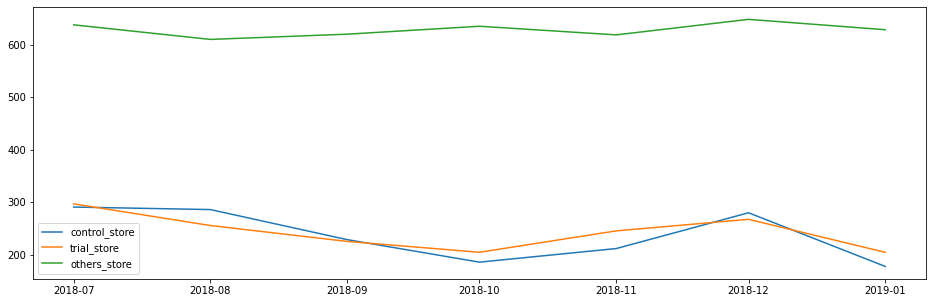

In [230]:
#Visualise
plt.figure(figsize=(16,5))
plt.plot(combine_Sales_plots)
plt.legend(combine_Sales_plots.columns)
plt.show()

* the drivers are 
indeed similar in the period before the trial.

In [231]:
## FOR NUMBER OF CUSTOMERS
#create df to plot 
control_ncus_plot=pastSales.loc[pastSales["storeTypes"]=="control_store",["TransactionMonth","numCust"]]
control_ncus_plot.set_index("TransactionMonth",inplace=True)

trial_ncus_plot=pastSales.loc[pastSales["storeTypes"]=="trial_store",["TransactionMonth","numCust"]]
trial_ncus_plot.set_index("TransactionMonth",inplace=True)

others_ncus_plot=pastSales.loc[pastSales["storeTypes"]=="other_stores",["TransactionMonth","numCust"]]
others_ncus_plot=pd.DataFrame(others_ncus_plot.groupby("TransactionMonth")["numCust"].mean())
others_ncus_plot


,numCust
TransactionMonth,
2018-07-01,72.333333
2018-08-01,72.120155
2018-09-01,70.131783
2018-10-01,71.608527
2018-11-01,70.534884
2018-12-01,73.515504
2019-01-01,71.240310


In [233]:
#combine them into one df
combine_nCus_plots=pd.concat([control_ncus_plot,trial_ncus_plot,others_ncus_plot],axis=1)
combine_nCus_plots.columns=["control_store","trial_store","others_store"]
combine_nCus_plots

,control_store,trial_store,others_store
TransactionMonth,,,
2018-07-01,51,51,72.333333
2018-08-01,48,47,72.120155
2018-09-01,42,42,70.131783
2018-10-01,35,37,71.608527
2018-11-01,40,41,70.534884
2018-12-01,47,46,73.515504
2019-01-01,35,35,71.240310


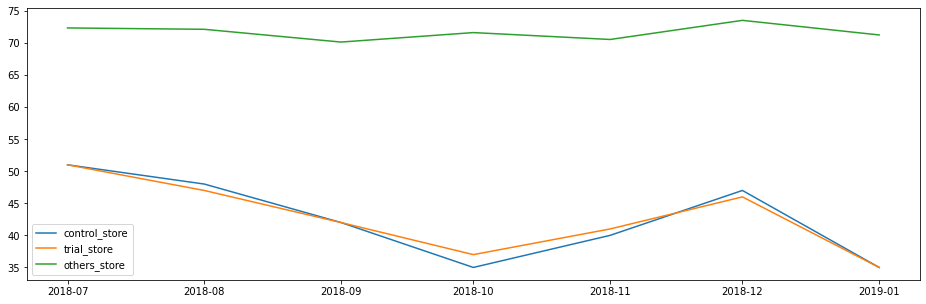

In [235]:
#Visualise
plt.figure(figsize=(16,5))
plt.plot(combine_nCus_plots)
plt.legend(combine_nCus_plots.columns)
plt.show()

* the drivers are 
indeed similar in the period before the trial.